# Assignment 4: Word Embeddings 

Welcome to the fourth programming assignment of Course 2. In this assignment we will show you how to compute the word embeddings. In Natural Language Processing (NLP) we can not only rely on counting the number of positive words and negative words, as we did in the last course using logistic regression. Instead we will try to find a way to represent each word by a vector. The vector could then represent syntactic (i.e. parts of speech) and semantic (i.e. meaning) structures. In this assignment you will explore a classic way of learning embeddings, or representations, of words by using a famous model called the continuous bag of words (CBOW) model. By completing this assignment you will:

- Train word vectors from scratch.
- Learn how to create batches of data.
- Understand how backpropagation works.
- Plot and visualize your learned word vectors.

Because it will take a while to train your CBOW model, you will code the model and make sure to get the expected outputs. We will give you some slightly pre-trained vectors and then you will fine tune them on the Shakespeare dataset. 

Knowing how to train these models will give you a better understanding of word vectors, which are building blocks to many applications in natural language processing.


# 1.0 The Continuous bag of words model

Let's take a look at the following sentence: **'I am happy because I am learning'**. In continuous bag of words modeling we try to predict the center word given a few context words. For example, if you were to choose a context (say $C = 2$), then you would try to predict the word **happy** given the context: {I, am, because, I}. In other words, you have

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of your model will look like this:


<div style="width:image width px; font-size:100%; text-align:center;"><img src='word2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 1 </div>

Where $\bar x$ is the average one hot vector for all the context word encodings. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='mean_vec2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 2 </div>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model. The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [1]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca, get_dict

In [2]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [3]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
data = open('shakespeare.txt').read()                               #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60975 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [4]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5777
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [5]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5777


In [6]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2744
Word which has index 2743:   kinds


# 2.0 Training the Model

###  Initializing the model

You will now initialize two matrices and two vectors. <br> The first matrix ($W_1$) is of dimension $V \times N$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector. <br>
The second matrix ($W_2$) is of dimension $N \times V$. 
The two vectors, $b_1$ and $b_2$ are of dimension $N\times 1$ and $V\times 1$ respectively (column vectors). $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.
The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters. 


In [23]:
np.random.seed(1)
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# GRADED FUNCTION: initialize_model
def initialize_model(N,V):
    ### START CODE HERE ###
    W1 = np.random.rand(N,V)
    W2 = np.random.rand(V,N)
    b1 = np.random.rand(N,1)
    b2 = np.random.rand(V,1)     
    ### END CODE HERE ###
    return W1, W2, b1, b2

In [24]:
# Test your function example.
N = 4
V = 10
W1, W2, b1, b2 = initialize_model(N,V)
assert W1.shape == ((N,V))
assert W2.shape == ((V,N))
print(W1.shape, W2.shape, b1.T)

(4, 10) (10, 4) [[0.88330609 0.62367221 0.75094243 0.34889834]]


* **Expected Output:**  (4, 10) (10, 4) [[0.88330609 0.62367221 0.75094243 0.34889834]]

### Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i} e^{z_i} }  \tag{5} $$


**Instructions**: Implement the softmax function below. 

In [25]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# GRADED FUNCTION: softmax
def softmax(x):
    """Compute softmax values for each sets of scores in x."""

    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR OWN CODE) ###
    s = (np.exp(x) / np.sum(np.exp(x), axis=0)).T
    
    ### END CODE HERE ###
    return s

In [26]:
# testing the softmax function 
print(softmax([0,3,-2])) 

[0.04712342 0.94649912 0.00637746]


**Expected Ouput:**  array([0.04712342, 0.94649912, 0.00637746])

### Forward propagation

Implement the forward propagation $z$ according to equations (1) to (3). <br>
For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

In [27]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# GRADED FUNCTION: forward_prop
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
        h:  output of first hidden layer
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR OWN CODE) ###
    ### (YOU WILL NEED TO ADD CODE IN ADDITION TO JUST REPLACING THE 'None' VALUES) ###
    
    # Calculate h and then used it to calculate z
    h = np.dot(W1,x) + b1   
    h[h<=0.0] = 0.0                     # this is the ReLU function
    z = np.dot(W2, h) + b2

#  h and z must be column vector for the solution to be right
    h = h.T
    z = z.T
    
    ### END CODE HERE ###

    return z, h

## Cost function

We have implemented the *cross-entropy* cost function for you. <br>
If you want to understand it better, we refer to a [good explanation](https://cs224d.stanford.edu/lecture_notes/notes1.pdf).

In [32]:
try:
    from scipy.misc import logsumexp
except ImportError:
    from scipy.special import logsumexp

# compute_cost: cross-entropy cost function,
def compute_cost(z, C, y, yhat, batch_size):
    z_hat = logsumexp(z, axis=-1, keepdims=True)                      
    cost = (-np.sum(y*np.log(yhat)) + np.sum(2.0*C*z_hat)) / batch_size
    return cost

##  Training the Model

Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.

In [29]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# GRADED FUNCTION: back_prop
def back_prop(x, z, y, h, W1, W2, b1, b2, batch_size, m):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        z:  score vector
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
        m:  number of context words
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR OWN CODE) ###
    ### (YOU WILL NEED TO ADD CODE IN ADDITION TO JUST REPLACING THE 'None' VALUES) ###
    l1 = np.dot(W2.T, (z - y))
    l1[l1<0] = 0.0
    
    grad_W2 = (1.0/(batch_size*m)) * np.dot((z - y), h)

    grad_b2 = (1.0/(batch_size*m)) * np.sum((z - y), axis = 1, keepdims=True)
    
    grad_b1 = (1.0/(batch_size*m)) * np.sum(l1, axis = 1, keepdims=True)

    grad_W1 = (1.0/(batch_size*m)) * np.dot(l1, x.T)
    ### END CODE HERE ###

    return grad_W1, grad_W2, grad_b1, grad_b2

Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set. 

**Hint:** For that, you will use initialize_model and the back_prop function that you just created (and the compute_cost function). You can also use the provided get_batches helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

```...```

Also: print the cost after each batch is processed (use batch size = 128)

In [30]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# GRADED FUNCTION: gradient_descent
def gradient_descent(data, word2Ind, C, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        C:         context window
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V) #W1=(N,V) and W2=(V,N)
    m = (2*C)
    batch_size = 128
    iters = 0
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(z, C, y, yhat, batch_size)
        print('iters', iters + 1 , '   cost',cost)
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size, m)
        W1 = W1 - alpha * grad_W1 
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1 
        b2 = b2 - alpha * grad_b2
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
    
        ### END CODE HERE ###

    return W1, W2, b1, b2

In [33]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 15
W1, W2, b1, b2 = gradient_descent(data, word2Ind, C, N, V, num_iters)

iters 1    cost 159.459353013221
iters 2    cost 135.04677235814708
iters 3    cost 111.63198667805563
iters 4    cost 89.75967845163359
iters 5    cost 71.26761559927665
iters 6    cost 57.03879565747018
iters 7    cost 46.90182477839866
iters 8    cost 42.25843129148009
iters 9    cost 41.648730386152245
iters 10    cost 41.64850422580056
iters 11    cost 41.648278127273265
iters 12    cost 41.64805209103558
iters 13    cost 41.64782611755612
iters 14    cost 41.64760020730713
iters 15    cost 41.64737436076431


**Expected Output:** iters 15 cost 41.66082959286652

## 3.0 Visualizing the word vectors

In this part you will visualize the word vectors trained using the function you just coded above. 

In [34]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2744, 3950, 2960, 3022, 5674, 1452, 2472, 4190, 2316, 4277]


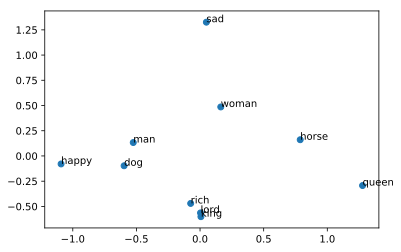

In [35]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

You can see that woman and queen are next to each other. However, we have to be carefull with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

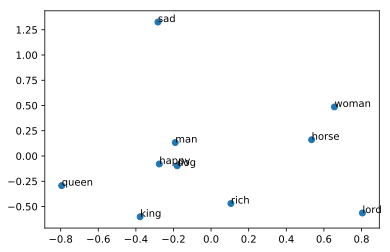

In [36]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()